Following the Baselines and Bigrams: Simple, Good Sentiment and Topic Classification paper
Specifically trying MNB and NBSVM
https://www.aclweb.org/anthology/P12-2018

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.model_selection import GridSearchCV, train_test_split
import spacy
import time
nlp = spacy.load('en')
%matplotlib inline

In [5]:
df = pd.read_csv('train.csv')
X_train, X_test, y_train, y_test = train_test_split(df[['comment_text']],
                                                    df.drop(columns=['id', 'comment_text']),
                                                    test_size=0.2)
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [6]:
nlp.vocab[u'you'].is_stop = False

In [7]:
def tokenize(s):
    tokens = nlp(unicode(s))
    return [t.lemma_ if t.lemma_ != u'-PRON-' else t.text for t in tokens if not t.is_stop and not t.is_space and not t.is_punct]

In [8]:
tfidf_vec = TfidfVectorizer(strip_accents='unicode', tokenizer=tokenize, ngram_range=(1,2),
                            max_df=0.9, min_df=3, sublinear_tf=True)

In [9]:
X_train_tfidf = tfidf_vec.fit_transform(X_train.comment_text)
X_test_tfidf = tfidf_vec.transform(X_test.comment_text)

In [10]:
def get_r(X, y_pos, y_neg, alpha=1.):
    p = X[y_pos].sum(0) + alpha
    q = X[y_neg].sum(0) + alpha
    
    p /= sum(p) + alpha
    q /= sum(q) + alpha
    
    return np.log(p, q).A1

In [11]:
lr = LogisticRegression()

In [13]:
search_params = {
    'tol': [1e-3, 1e-4],
    'C': [1., 4., 8.]
}

In [14]:
best_params = {}
best_estimators = {}
rs = {}
best_score = {}
test_score = {}
for c in classes:
    print 'Training {}'.format(c)
    t = time.time()
    y_pos = y_train[y_train[c] == 1][c].values
    y_neg = y_train[y_train[c] == 0][c].values
    r = get_r(X_train_tfidf, y_pos, y_neg)
    clf = GridSearchCV(lr, search_params, scoring='neg_log_loss', cv=10)
    clf.fit(X_train_tfidf.multiply(r), y_train[c].values)
    best_params[c] = clf.best_params_
    best_estimators[c] = clf.best_estimator_
    rs[c] = r
    best_score[c] = clf.best_score_
    test_score[c] = log_loss(y_test[c].values, clf.best_estimator_.predict_proba(X_test_tfidf.multiply(r))[:,1])
    print 'Took {} seconds'.format(time.time() - t)

Training toxic
Took 89.8988058567 seconds
Training severe_toxic
Took 96.6403999329 seconds
Training obscene
Took 82.8631799221 seconds
Training threat
Took 83.1969339848 seconds
Training insult
Took 92.8038561344 seconds
Training identity_hate
Took 93.2877600193 seconds


In [15]:
print 'Mean Validation score: {}'.format(np.mean(best_score.values()))
print 'Mean Test score: {}'.format(np.mean(test_score.values()))

Mean Validation score: -0.0549391238363
Mean Test score: 0.051522885159


In [16]:
print 'Best parameters by Class:'
for c in classes:
    print c, best_params[c]
    print 'Confusion matrix'
    print confusion_matrix(y_test[c], [1 if x > 0.5 else 0 for x in best_estimators[c].predict_proba(X_test_tfidf.multiply(rs[c]))[:,1]])

Best parameters by Class:
toxic {'C': 8.0, 'tol': 0.0001}
Confusion matrix
[[17243   144]
 [  616  1168]]
severe_toxic {'C': 8.0, 'tol': 0.0001}
Confusion matrix
[[18929    39]
 [  153    50]]
obscene {'C': 8.0, 'tol': 0.001}
Confusion matrix
[[18070    75]
 [  347   679]]
threat {'C': 8.0, 'tol': 0.001}
Confusion matrix
[[19112     6]
 [   40    13]]
insult {'C': 8.0, 'tol': 0.001}
Confusion matrix
[[18108   126]
 [  419   518]]
identity_hate {'C': 8.0, 'tol': 0.001}
Confusion matrix
[[19006    12]
 [  121    32]]


False Negative rate is really high likely due to severe class imbalance.
Try using scoring based on Recall (TP / FN + TP) to lower this specific problem.

In [21]:
from sklearn.metrics import recall_score

In [27]:
recall_search_params = {
    'C': [8.],
    'class_weight': [None, 'balanced']
}

In [28]:
recall_params = {}
recall_estimators = {}
recall_rs = {}
best_recall_score = {}
recall_test_score = {}
for c in classes:
    print 'Training {}'.format(c)
    t = time.time()
    y_pos = y_train[y_train[c] == 1][c].values
    y_neg = y_train[y_train[c] == 0][c].values
    r = get_r(X_train_tfidf, y_pos, y_neg)
    clf = GridSearchCV(lr, recall_search_params, scoring='recall', cv=10)
    clf.fit(X_train_tfidf.multiply(r), y_train[c].values)
    recall_params[c] = clf.best_params_
    recall_estimators[c] = clf.best_estimator_
    recall_rs[c] = r
    best_recall_score[c] = clf.best_score_
    recall_test_score[c] = recall_score(y_test[c].values, [1 if p > 0.5 else 0 for p in clf.best_estimator_.predict_proba(X_test_tfidf.multiply(r))[:,1]])
    print 'Took {} seconds'.format(time.time() - t)

Training toxic
Took 52.8287889957 seconds
Training severe_toxic
Took 49.6430139542 seconds
Training obscene
Took 45.3084440231 seconds
Training threat
Took 44.3171460629 seconds
Training insult
Took 49.5966539383 seconds
Training identity_hate
Took 50.8987498283 seconds


In [29]:
print 'Mean Validation score: {}'.format(np.mean(best_recall_score.values()))
print 'Mean Test score: {}'.format(np.mean(recall_test_score.values()))

Mean Validation score: 0.702062123202
Mean Test score: 0.755434283385


In [30]:
print 'Best parameters by Class:'
for c in classes:
    print c, recall_params[c]
    print 'Confusion matrix'
    print confusion_matrix(y_test[c], [1 if x > 0.5 else 0 for x in recall_estimators[c].predict_proba(X_test_tfidf.multiply(rs[c]))[:,1]])

Best parameters by Class:
toxic {'C': 8.0, 'class_weight': 'balanced'}
Confusion matrix
[[16796   591]
 [  299  1485]]
severe_toxic {'C': 8.0, 'class_weight': 'balanced'}
Confusion matrix
[[18669   299]
 [   61   142]]
obscene {'C': 8.0, 'class_weight': 'balanced'}
Confusion matrix
[[17864   281]
 [  169   857]]
threat {'C': 8.0, 'class_weight': 'balanced'}
Confusion matrix
[[19045    73]
 [   17    36]]
insult {'C': 8.0, 'class_weight': 'balanced'}
Confusion matrix
[[17750   484]
 [  163   774]]
identity_hate {'C': 8.0, 'class_weight': 'balanced'}
Confusion matrix
[[18810   208]
 [   52   101]]


In [79]:
df_train_prob = pd.DataFrame(np.array([best_estimators[c].predict_proba(X_train_tfidf.multiply(rs[c]))[:,1],
                                       recall_estimators[c].predict_proba(X_train_tfidf.multiply(rs[c]))[:,1],
                                       y_train[c]]).T,
                            columns=['unbalanced', 'balanced', 'actual'])

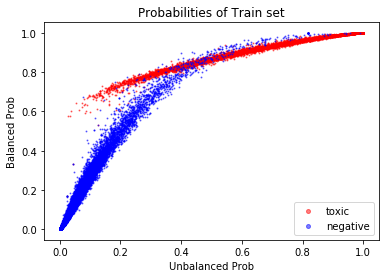

In [89]:
plt.scatter(df_train_prob[df_train_prob.actual == 1].unbalanced,
            df_train_prob[df_train_prob.actual == 1].balanced,
            color='red', label=c, alpha=0.5, s=1)
plt.scatter(df_train_prob[df_train_prob.actual == 0].unbalanced,
            df_train_prob[df_train_prob.actual == 0].balanced,
            color='blue', label='negative', alpha=0.5, s=1)
plt.xlabel('Unbalanced Prob')
plt.ylabel('Balanced Prob')
plt.title('Probabilities of Train set')
plt.legend(loc=4, markerscale=4)
plt.show()

Overfitting

In [85]:
df_test_prob = pd.DataFrame(np.array([best_estimators[c].predict_proba(X_test_tfidf.multiply(rs[c]))[:,1],
                                      recall_estimators[c].predict_proba(X_test_tfidf.multiply(rs[c]))[:,1],
                                      y_test[c]]).T,
                            columns=['unbalanced', 'balanced', 'actual'])

/home/gabriel/.virtualenvs/toxic_classification_kaggle/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/gabriel/.virtualenvs/toxic_classification_kaggle/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/gabriel/.virtualenvs/toxic_classification_kaggle/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/gabriel/.virtualenvs/toxic_classification_kaggle/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


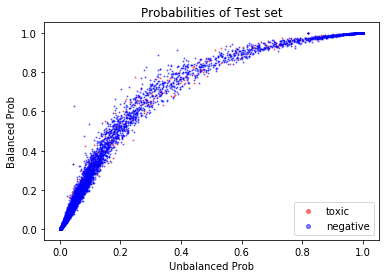

In [88]:
plt.scatter(df_test_prob[df_train_prob.actual == 1].unbalanced,
            df_test_prob[df_train_prob.actual == 1].balanced,
            color='red', label=c, alpha=0.5, s=1)
plt.scatter(df_test_prob[df_train_prob.actual == 0].unbalanced,
            df_test_prob[df_train_prob.actual == 0].balanced,
            color='blue', label='negative', alpha=0.5, s=1)
plt.xlabel('Unbalanced Prob')
plt.ylabel('Balanced Prob')
plt.title('Probabilities of Test set')
plt.legend(loc=4, markerscale=4)
plt.show()

## Output for submission

In [91]:
tfidf_vec_submission = TfidfVectorizer(strip_accents='unicode', tokenizer=tokenize, ngram_range=(1,2),
                            max_df=0.9, min_df=3, sublinear_tf=True)

In [93]:
X = tfidf_vec_submission.fit_transform(df.comment_text)
y = df.drop(columns=['id', 'comment_text'])

In [94]:
df_test = pd.read_csv('test.csv')

In [98]:
df_test.comment_text.fillna('no text', inplace=True)

In [100]:
X_sub = tfidf_vec_submission.transform(df_test.comment_text)

In [103]:
test_pred = np.zeros((len(df_test), len(classes)))
for i, c in enumerate(classes):
    lr = LogisticRegression(**best_params[c])
    y_pos = y[y[c] == 1][c].values
    y_neg = y[y[c] == 0][c].values
    r = get_r(X, y_pos, y_neg)
    lr.fit(X.multiply(r), y[c].values)
    test_pred[:,i] = lr.predict_proba(X_sub.multiply(r))[:,1]

In [104]:
df_sub = pd.concat([df_test.drop(columns=['comment_text']), pd.DataFrame(test_pred, columns = classes)], axis=1)
df_sub.to_csv('nblr_submission.csv', index=False)

Got a 0.053 on the test set, which is not bad. Looked at some other submissions using similar methods and it looks like doing TFIDF on characters may have better performance.